# The Facility Dispersion Problem

## p-dispersion

$$
\begin{align}
    \text{max} \quad & D \\
    \text{s.t} \quad & \sum_{i \in V} x_{i} = p & \forall \; i \in V \\
    & z_{i, j} \leq x_{i} & \forall \; i, j \in A \\
    & z_{i, j} \leq x_{j} & \forall \; i, j \in A \\
    & x_{i} + x_{j} - 1 \leq z_{i, j} & \forall \; i, j \in A \\
    & D \leq d_{i, j} + M (1 - z_{i, j}) & \forall \; i, j \in A \\
    & x_{i} \in \{0, 1\} & \forall \; i \in V \\
    & z_{i, j} \in \{0, 1\} & \forall \; i, j \in A \\
\end{align}
$$

## maxisum

$$
\begin{align}
    \text{max} \quad & \sum_{i \in V}\sum_{j \in V} d_{i, j} z_{i, j} \\
    \text{s.t} \quad & d_{opt} \leq D \\
\end{align}
$$

In [28]:
import json

import numpy as np
from scipy.spatial.distance import pdist, squareform
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Read input data

In [29]:
# Read file
with open("./data/data_300_15.json", mode="r") as file:
    data = json.load(file)

N = len(data["coordinates"])
coordinates = np.array(data["coordinates"])
weights = squareform(pdist(coordinates))

# Number of points to select
p = data["p"]

In [30]:
data

{'coordinates': [[0.15416284237967237, 0.7400496965154048],
  [0.26331501518513467, 0.5337393933802977],
  [0.014574962485419674, 0.918747008099885],
  [0.9007148541170122, 0.03342142762634459],
  [0.9569493362751168, 0.13720932135607644],
  [0.28382835295794584, 0.6060831843588289],
  [0.9442251360530421, 0.852735541109285],
  [0.002259233518513537, 0.5212260272202929],
  [0.5520376332645666, 0.4853774136627097],
  [0.7681341540644223, 0.1607167531255701],
  [0.7645604503388788, 0.020809797952066167],
  [0.13521017836911686, 0.11627301740168983],
  [0.30989758449002924, 0.6714526452120027],
  [0.4712297782500141, 0.8161682980460269],
  [0.28958678353055356, 0.7331259776126706],
  [0.7026223552552463, 0.32756947626342303],
  [0.3346475291060558, 0.9780580790165189],
  [0.6245821117353524, 0.9503135246995253],
  [0.7674756506204887, 0.8250092532147735],
  [0.40664030180666166, 0.4513084114213143],
  [0.40063162736167357, 0.9951381603385585],
  [0.1775641759378893, 0.9625969030278503],
 

In [31]:
N

300

In [32]:
coordinates

array([[0.15416284, 0.7400497 ],
       [0.26331502, 0.53373939],
       [0.01457496, 0.91874701],
       [0.90071485, 0.03342143],
       [0.95694934, 0.13720932],
       [0.28382835, 0.60608318],
       [0.94422514, 0.85273554],
       [0.00225923, 0.52122603],
       [0.55203763, 0.48537741],
       [0.76813415, 0.16071675],
       [0.76456045, 0.0208098 ],
       [0.13521018, 0.11627302],
       [0.30989758, 0.67145265],
       [0.47122978, 0.8161683 ],
       [0.28958678, 0.73312598],
       [0.70262236, 0.32756948],
       [0.33464753, 0.97805808],
       [0.62458211, 0.95031352],
       [0.76747565, 0.82500925],
       [0.4066403 , 0.45130841],
       [0.40063163, 0.99513816],
       [0.17756418, 0.9625969 ],
       [0.41925027, 0.42405245],
       [0.46314887, 0.37372315],
       [0.4655081 , 0.03516826],
       [0.08427267, 0.7325207 ],
       [0.63619999, 0.02790779],
       [0.30017006, 0.22085252],
       [0.05501999, 0.52324607],
       [0.41636966, 0.04821875],
       [0.

In [33]:
weights

array([[0.        , 0.23340552, 0.22675428, ..., 0.69311889, 0.15235627,
        0.48964162],
       [0.23340552, 0.        , 0.45836937, ..., 0.46918595, 0.2052451 ,
        0.28468901],
       [0.22675428, 0.45836937, 0.        , ..., 0.91959327, 0.34518282,
        0.71352566],
       ...,
       [0.69311889, 0.46918595, 0.91959327, ..., 0.        , 0.59876603,
        0.21819243],
       [0.15235627, 0.2052451 , 0.34518282, ..., 0.59876603, 0.        ,
        0.38310049],
       [0.48964162, 0.28468901, 0.71352566, ..., 0.21819243, 0.38310049,
        0.        ]])

In [34]:
p

15

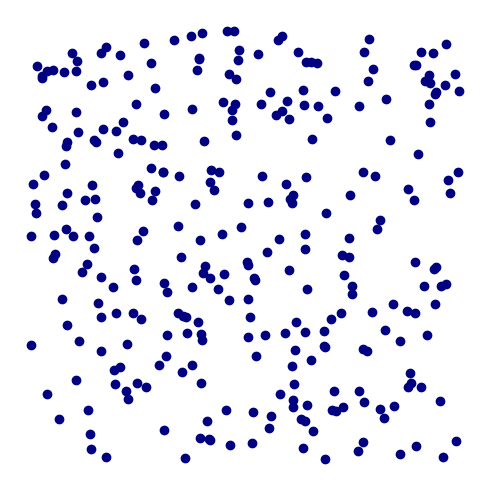

In [35]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=100)
ax.scatter(
    coordinates[:, 0],
    coordinates[:, 1],
    color="navy"
)

ax.axis('off')

fig.tight_layout()
plt.show()

## pyomo model

In [36]:
# Instantiate pyomo ConcreteModel
model = pyo.ConcreteModel()

In [37]:
# Sets of nodes and arcs
model.V = pyo.Set(initialize=range(N))
model.A = pyo.Set(
    initialize=[(i,j) for i in range(N)
                for j in range(N) 
                if i != j]
)

In [38]:
# Parameters
model.d = pyo.Param(model.A, initialize={(i,j): weights[i, j] for (i,j) in model.A})
model.p = pyo.Param(initialize=p)

# # Big M
model.M = pyo.Param(initialize=max(model.d[:,:]) - min(model.d[:,:]))

In [39]:
# Decision variables
model.x = pyo.Var(model.V, within=pyo.Binary)
model.z = pyo.Var(model.A, within=pyo.Binary)
model.D = pyo.Var(within=pyo.NonNegativeReals)

In [40]:
# Constraints
def p_selection(model):
    return sum(model.x[:]) == model.p


def dispersion_c1(model,i,j):
    return model.z[i,j] <= model.x[i]


def dispersion_c2(model,i,j):
    return model.z[i,j] <= model.x[j]


def dispersion_c3(model,i,j):
    return model.x[i] + model.x[j] - 1 <= model.z[i,j]


def maxmin_rule(model,i,j):
    return model.D <= model.d[i,j] + model.M * (1 - model.z[i,j])


# Set model attributes
model.p_selection = pyo.Constraint(rule=p_selection)
model.dispersion_c1 = pyo.Constraint(model.A, rule=dispersion_c1)
model.dispersion_c2 = pyo.Constraint(model.A, rule=dispersion_c2)
model.dispersion_c3 = pyo.Constraint(model.A, rule=dispersion_c3)
model.maxmin_rule = pyo.Constraint(model.A, rule=maxmin_rule)

In [41]:
# Objectives
model.obj_pdisp = pyo.Objective(expr=model.D, sense=pyo.maximize)


def obj_maxisum(model):
    return sum(model.d[i,j] * model.z[i,j] for (i,j) in model.A)


model.obj_maxisum = pyo.Objective(rule=obj_maxisum, sense=pyo.maximize)
model.obj_maxisum.deactivate()

## Solve

In [42]:
# Function to solve model
def solve_model(model, solver, **kwargs):

    # Solve p-dispersion problem
    solver.solve(model, **kwargs)

    # Include constraint that does not allow objective degradation
    d_opt = model.obj_pdisp()
    model.pdisp_degradation = pyo.Constraint(expr=d_opt <= model.D)

    # Change active objective
    model.obj_pdisp.deactivate()
    model.obj_maxisum.activate()

    # Solve maxisum model
    solver.solve(model, **kwargs)

In [43]:
solver = pyo.SolverFactory("appsi_highs")
solver.options["time_limit"] = 180
solve_model(model, solver, tee=True)

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
358800 rows, 90001 cols, 807598 nonzeros  0s
358799 rows, 89999 cols, 807596 nonzeros  1s

Solving MIP model with:
   358799 rows
   89999 cols (89998 binary, 0 integer, 0 implied int., 1 continuous)
   807596 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   1.3163601       -inf                 inf        0      0      0         0     2.1s
 R       0       0         0   0.00%   1.3163601       0.0237679527    5438.38%        0      0      0        33     3.9s
 C       0       0         0   0.00%   1.3163601       0.0439671276 

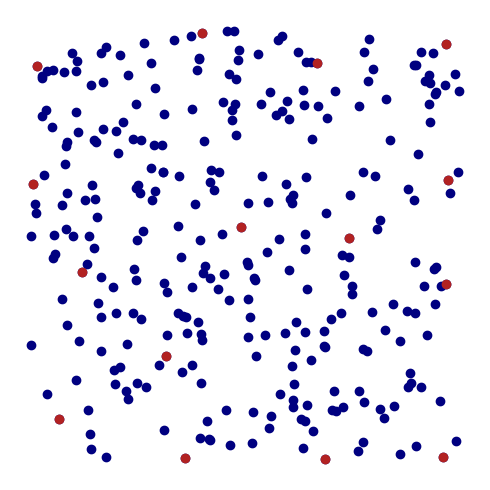

In [44]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=100)
facilities = np.array([i for i in model.x if np.isclose(model.x[i].value, 1)])

ax.scatter(
    coordinates[:, 0],
    coordinates[:, 1],
    color="navy"
)

ax.scatter(
    coordinates[facilities, 0],
    coordinates[facilities, 1],
    color="firebrick",
    label="Facilities"
)

ax.axis('off')

fig.tight_layout()
plt.show()